## 1. Import Required Packages <a class="anchor" id="1"></a>

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext


In [3]:
spark = SparkSession.builder.appName('Covid-19 Classifier').getOrCreate()
spark

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import itertools

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Data Preparation <a class="anchor" id="2"></a>

In [2]:
def import_image_to_array(directory_path, size):
    
    """
    Argument:
        directory_path - The path to the directory of the images to be imported.
        size - a tuple that describes the desired size to be imported 
    
    Task(s) this function carry out:
        Import images from the specified dirctories and convert them to arrays/tensors
    
    Returns:
        image_arrays - arrays of the images imported
    
    """
    # Define empty lists to store the images array and their respective labels
    image_arrays = []
    
    directory = os.listdir(directory_path)

    for image_name in directory:
        
        # Load an image from the specified directory
        image = cv2.imread(directory_path + image_name)
            
        # Resize image to the specified size
        image = cv2.resize(image, size)

        # Update the image dataset and labels lists respectively
        image_arrays.append(image)
            
    return image_arrays

In [4]:
import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))

from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit

# loaded image
covid_df = spark.read.format("image").load("COVID_IEEE/covid").withColumn("label", lit(0))
normal_df = spark.read.format("image").load("COVID_IEEE/normal").withColumn("label", lit(1))
virus_df = spark.read.format("image").load("COVID_IEEE/virus").withColumn("label", lit(2))

# merge data frame
from functools import reduce

dataframes = [covid_df,normal_df,virus_df]

df = reduce(lambda first, second: first.union(second), dataframes)

# repartition dataframe 
df = df.repartition(200)

# split the data-frame
train, test = df.randomSplit([0.8, 0.2], 42)

In [5]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: integer (nullable = false)



##### Initialize the function to create dataset


In [3]:
NORMAL_DIR = "COVID_IEEE/normal/"  # Normal CXR Image Dataset
VIRAL_DIR = "COVID_IEEE/virus/"    # Viral Pneumonia CXR Image Dataset
COVID_DIR = "COVID_IEEE/covid/"    # COVID-19 CXR Image Dataset

normal_dataset = import_image_to_array(NORMAL_DIR, (224,224))
viral_dataset = import_image_to_array(VIRAL_DIR, (224,224))
covid_dataset = import_image_to_array(COVID_DIR, (224,224))

In [4]:
print("The Dataset which is made up of {} Image Arrays has: ".format(len(normal_dataset) + len(viral_dataset) + len(covid_dataset)))
print('{} Normal CXR Image Arrays'.format(len(normal_dataset)))
print('{} Viral Pneumonia CXR Image Arrays'.format(len(viral_dataset)))
print('{} COVID-19 CXR Image Arrays'.format(len(covid_dataset)))

The Dataset which is made up of 1823 Image Arrays has: 
668 Normal CXR Image Arrays
619 Viral Pneumonia CXR Image Arrays
536 COVID-19 CXR Image Arrays


#####  Preview some of the images from the created datasets

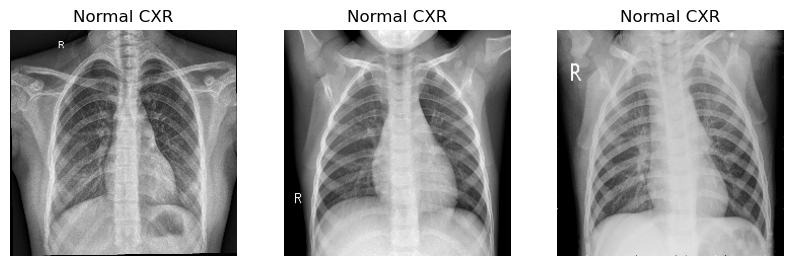

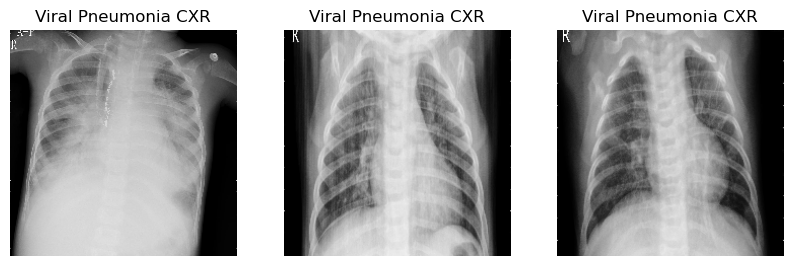

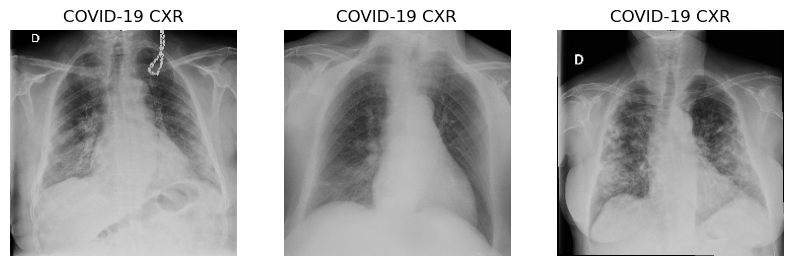

In [5]:
class_names = {0: "Normal CXR", 1 : "Viral Pneumonia CXR", 2: "COVID-19 CXR"}

# Normal CXR Sampling
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(normal_dataset[images], cmap = "gray")
    plt.title(class_names[0])
    plt.axis("off")
    
# Viral Pneumonia CXR Sampling
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(viral_dataset[images], cmap = "gray")
    plt.title(class_names[1])
    plt.axis("off")
    
# COVID-19 CXR Sampling
plt.figure(figsize=(10, 10))
for images in range(3):
    ax = plt.subplot(3, 3, images + 1)
    plt.imshow(covid_dataset[images], cmap = "gray")
    plt.title(class_names[2])
    plt.axis("off")

##### Key Observations from the above sample images :

1. Normal CXR Images have clear lungs 
2. Viral Pneumonia CXR Images have slight congestion in lungs
3. COVID-19 images have serious congestion in lungs

In [6]:
def white_balance(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [7]:
def clahe():
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    return clahe

In [8]:
def image_enhancer(image_arrays):
    
    """
    Argument: 
    image_arrays: a list containing arrays of images to be normalized
    
    returns:
    enhanced_images: a list of the enhanced images arrays
    """
    enchanced_images = []
    
    for image in image_arrays:
        
        # White Balance
        image_WB  = np.dstack([white_balance(channel, 0.05) for channel in cv2.split(image)] )
        gray_image = cv2.cvtColor(image_WB, cv2.COLOR_RGB2GRAY)

        # CLAHE
        clahe_function = clahe()
        image_clahe = clahe_function.apply(gray_image)
        image = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        
        enchanced_images.append(image)
    
    return enchanced_images

##### Enhance the chest x-ray images using the predefined function

In [9]:
normal_dataset_enhanced = image_enhancer(normal_dataset) 
viral_dataset_enhanced = image_enhancer(viral_dataset)
covid_dataset_enhanced = image_enhancer(covid_dataset)

##### Preview the differences between the normal images and the enhanced images

(-0.5, 223.5, 223.5, -0.5)

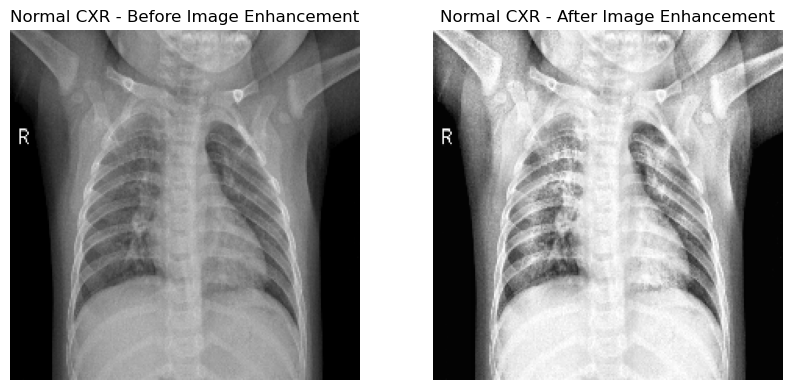

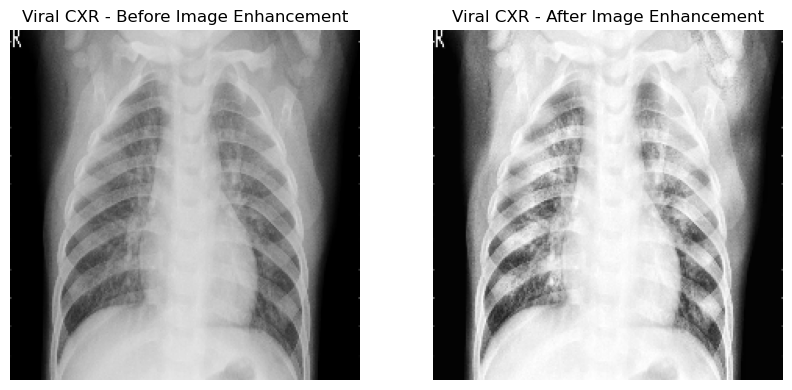

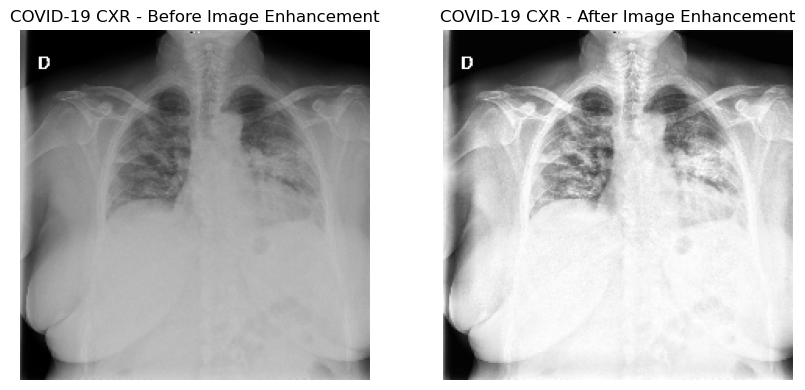

In [10]:
# Normal CXR Sampling
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(normal_dataset[100], cmap = "gray")
plt.title("Normal CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(normal_dataset_enhanced[100], cmap = "gray")
plt.title("Normal CXR - After Image Enhancement")
plt.axis("off")
    
# Viral Pneumonia CXR Sampling
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(viral_dataset[100], cmap = "gray")
plt.title("Viral CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(viral_dataset_enhanced[100], cmap = "gray")
plt.title("Viral CXR - After Image Enhancement")
plt.axis("off")
    
# COVID-19 CXR Sampling
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(covid_dataset[100], cmap = "gray")
plt.title("COVID-19 CXR - Before Image Enhancement")
plt.axis("off")

ax = plt.subplot(2, 2, 2)
plt.imshow(covid_dataset_enhanced[100], cmap = "gray")
plt.title("COVID-19 CXR - After Image Enhancement")
plt.axis("off")

#### Normalize Dataset

Normalization is a data preprocessing technique  in machine learning whose goal is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. The aim of normalization is to ensure data is in a great state to speed up our machine learning training. Hence, not every dataset require normalization. It is required only when features have different ranges.
Each value of a digital image array is always between 0 and 255. This great distortion could slow down how our model process and learn from the data (especially when our weights are often between 0 and 1). Hence, rescaling our model by dividing all of the array values by 255 (which is the highest achievable value of a digital image) will ensure all the values end up between 0 and 1. This speeds up our model training and also helps us achieve better results.

In [11]:
def normalizer(image_arrays):

    """
    Argument: 
        image_arrays: array of images to be normalized
    
    returns:
        normalized_images_array: array of the normalized images' arrays
    """
    # Create an empty list to store normalized arrays
    norm_image_arrays = []
    
    # Iterate over all the image arrays and normalize them before storing them into our predefined list
    for image_array in image_arrays:
        norm_image_array = image_array / 255.0
        norm_image_arrays.append(norm_image_array)
    
    return norm_image_arrays

In [12]:
normal_dataset_normalized = normalizer(normal_dataset)
viral_dataset_normalized = normalizer(viral_dataset)
covid_dataset_normalized = normalizer(covid_dataset)

#### Split datasets into training, validation, and test sets

In [13]:
def split_and_merge_function(image_arrays, split_factor = [0.7, 0.15, 0.15]):
    
    """
    Argument:
        image_arrays - A list or tuple of the images to be imported.
        data_labels - A list of the data labels
        split_factor - A list or tuple that determines how the dataset is splitted into training, validation and test dataset
    
    Task(s) carried out:
        Split the dataset into training, validation, and test sets
        Merge the sets of each categories
    
    Returns:
    datasets - a dictionary containing the training, validation and test datasets (arrays of the images imported 
                and their respective labels)
    
    """
    # Define an empty dictionary to hold the training, validation and test datasets
    datasets = {}
    # Calculate the number of image categories in the list argument passed to this function
    number_of_categories = len(image_arrays)   
    
    train_dataset, validation_dataset, test_dataset, train_labels, validation_labels, test_labels = [], [], [], [], [], []
    
    for image_array_id in range(number_of_categories):
        image_array = image_arrays[image_array_id]
        
        # Update the data and labels lists, respectively
        dataset = [[image_array[image_id], [image_array_id]] for image_id in range(len(image_array))]
            
        # Split the data and labels into the train, validation, and test datasets
        train_dataset.extend(np.array(dataset[ : int(np.around(len(dataset) * split_factor[0]))]))
        validation_dataset.extend(np.array(dataset[int(np.around(len(dataset) * split_factor[0])) : int(np.around(len(dataset) * (split_factor[0] + split_factor[1])))]))
        test_dataset.extend(np.array(dataset[int(np.around(len(dataset) * (split_factor[0] + split_factor[1]))) : ]))
        
        # Randomize the train, validation and test datasets
        random.seed(42) # Define a random state parameter to ensure the dataset generated is the same regardless of how many iterations we run
        random.shuffle(train_dataset), random.shuffle(validation_dataset), random.shuffle(test_dataset)
        
        # Split the data and label pairs and add them to the data and labels lists
        train_data = [dataset[0] for dataset in train_dataset]
        train_labels = [dataset[1] for dataset in train_dataset]
        validation_data = [dataset[0] for dataset in validation_dataset]
        validation_labels = [dataset[1] for dataset in validation_dataset]
        test_data = [dataset[0] for dataset in test_dataset]
        test_labels = [dataset[1] for dataset in test_dataset]
        
    
    # Store train, validation and test datasets into the datasets dictionary
    datasets['train_dataset'] = np.array(train_data)
    datasets['validation_dataset'] = np.array(validation_data)
    datasets['test_dataset'] = np.array(test_data)
    
    # Convert labels from label-encoding to one-hot encoding and store in the datasets dictionary     
    datasets['train_labels'] = to_categorical(np.array(train_labels))
    datasets['validation_labels'] = to_categorical(np.array(validation_labels))
    datasets['test_labels'] = to_categorical(np.array(test_labels))
        
    return datasets

##### Split our datasets using the predefined function

In [14]:
image_arrays = [normal_dataset_normalized, viral_dataset_normalized, covid_dataset_normalized]
datasets = split_and_merge_function(image_arrays, split_factor = [0.7, 0.15, 0.15])

In [15]:
train_dataset = datasets['train_dataset']
validation_dataset = datasets['validation_dataset']
test_dataset = datasets['test_dataset']
train_labels = datasets['train_labels'] 
validation_labels = datasets['validation_labels']
test_labels = datasets['test_labels']

In [16]:
print("The Dataset which is made up of {} Image Arrays has been splitted into:".format(len(train_dataset) + len(validation_dataset) + len(test_dataset)))
print('{} Training Image Arrays'.format(len(train_dataset)))
print('{} Validation Image Arrays'.format(len(validation_dataset)))
print('{} Test Image Arrays'.format(len(test_dataset)))

The Dataset which is made up of 1823 Image Arrays has been splitted into:
1276 Training Image Arrays
274 Validation Image Arrays
273 Test Image Arrays


#### Augment dataset

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In [17]:
def data_augmenter():
    """
    Create a simple function to augment training images
    Returns:
        tf.keras.Sequential

    """
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    
    return data_augmentation

##### Apply the data augmentation function on an image from the training dataset 

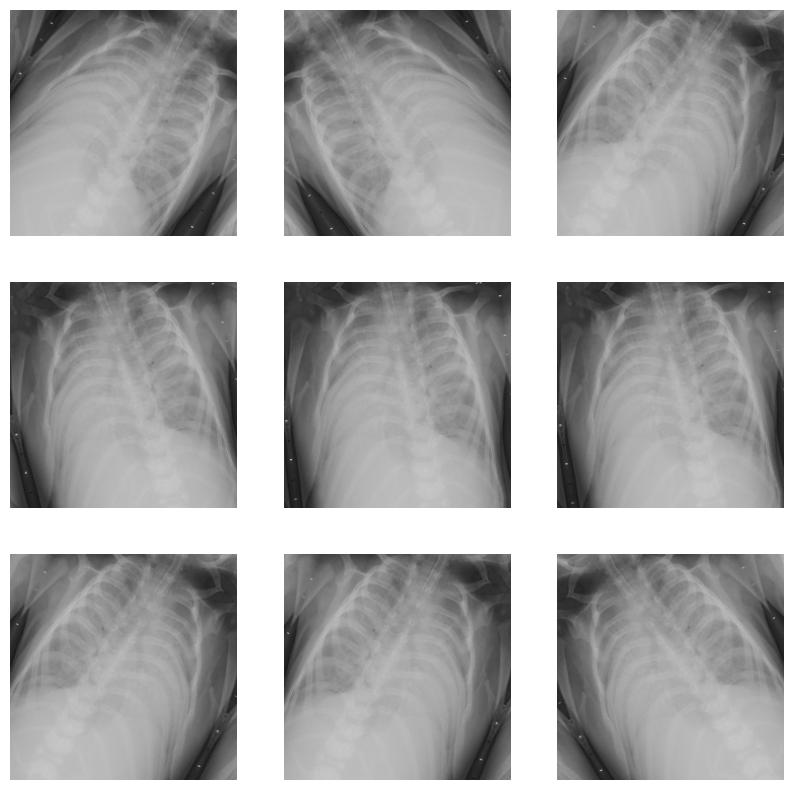

In [18]:
data_augmentation = data_augmenter()

plt.figure(figsize=(10, 10))
first_image = train_dataset[6]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    exp = tf.expand_dims(first_image, 0)
    augmented_image = data_augmentation(exp)
    plt.imshow(augmented_image[0])
    plt.axis('off')

## Transfer Learning Using MobileNetV2


Transfer learning is the re-use of a pre-trained model on a new problem. In transfer learning, a machine exploits the knowledge gained from a previous task to improve generalization about another. For example, in training a classifier to predict whether an image contains food, you could use the knowledge it gained during training to recognize drinks.

Transfer learning has several benefits, but the main advantages are  saving training time, better performance of neural networks (in most cases), and not needing a lot of data. 

The [**MobileNetV2**](https://arxiv.org/pdf/1801.04381.pdf) is a light-weight image classification model/algorithm developed by *Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, and Liang-Chieh Chen*. The model is based on an inverted residual structure where the input and output of the residual block are thin bottleneck layers opposite to traditional residual models which use expanded representations in the input an MobileNetV2 uses lightweight depthwise convolutions to filter features in the intermediate expansion layer.
The model was trained on Imagenet, and its performance was measured on Imagenet classification, COCO object detection, and VOC image segmentation.

#### Layer Freezing with Functional API

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [19]:
def make_mobilenet_model(image_size, num_classes, data_augmentation = data_augmenter()):
    
    input_shape = image_size + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False, # Do not include the dense prediction layer
                                                weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)
        
    # create a prediction layer
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    
    prediction_layer = Dense(units, activation=activation)
    
    outputs = prediction_layer(x)
    
    model = Model(inputs, outputs)
    
    return model

In [20]:
# Define a model using the make_model function
image_size = (224,224)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 3)

# Preview the Model Summary
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

In [21]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
            loss = loss,
            metrics = metrics)

In [22]:
mobilenet_history_freeze = mobilenet_model.fit(train_dataset, train_labels,
                                                batch_size = batch_size, 
                                                epochs = initial_epochs, 
                                                validation_data = (validation_dataset, validation_labels), 
                                                callbacks = [callback, reduce_lr], 
                                                shuffle = True)

Epoch 1/50
20/20 [==============================] - 10s 426ms/step - loss: 1.1257 - accuracy: 0.5455 - val_loss: 0.5556 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 5s 241ms/step - loss: 0.6085 - accuracy: 0.7367 - val_loss: 0.4633 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 5s 236ms/step - loss: 0.4470 - accuracy: 0.8190 - val_loss: 0.3477 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 5s 244ms/step - loss: 0.3818 - accuracy: 0.8440 - val_loss: 0.3303 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 5s 252ms/step - loss: 0.3625 - accuracy: 0.8644 - val_loss: 0.2806 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 5s 256ms/step - loss: 0.3180 - accuracy: 0.8840 - val_loss: 0.2682 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 5s 247ms/step - l

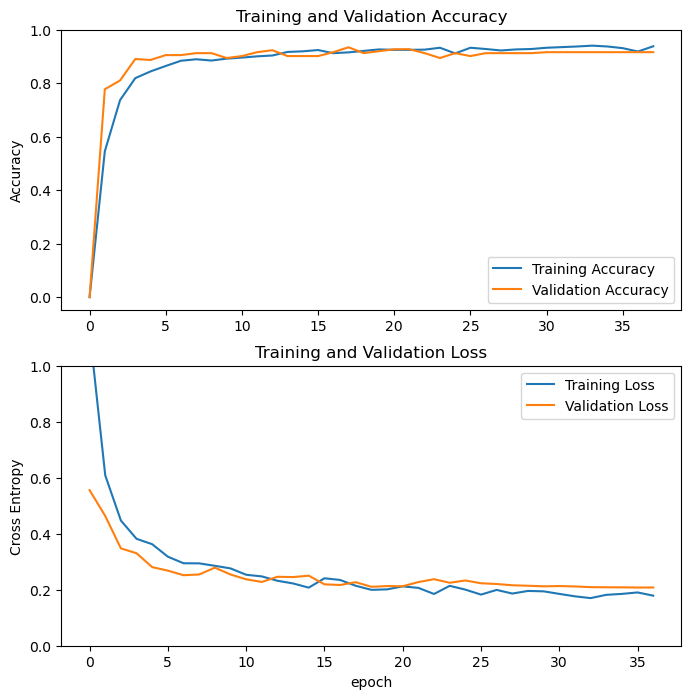

In [23]:
acc = [0.] + mobilenet_history_freeze.history['accuracy']
val_acc = [0.] + mobilenet_history_freeze.history['val_accuracy']

loss = mobilenet_history_freeze.history['loss']
val_loss = mobilenet_history_freeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

#### Fine-tuning the Model by re-running the optimizer in the last layers to improve accuracy

We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training our model on the final layers with a very low learning rate. Adapting the learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

In [24]:
base_mobilenet_model = mobilenet_model.layers[2] # MobileNetV2 Architecture
base_mobilenet_model.trainable = True

# The MobileNet Model has 155 layers (the prediction layer inclusive)
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = True


optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
                        loss = loss,
                        metrics = metrics)

In [25]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(train_dataset, train_labels,
                                            epochs = total_epochs,
                                            batch_size = batch_size,
                                            initial_epoch = mobilenet_history_freeze.epoch[-1],
                                            callbacks = [callback, reduce_lr], 
                                            validation_data = (validation_dataset, validation_labels),
                                            shuffle = True)

Epoch 37/80
20/20 [==============================] - 21s 865ms/step - loss: 0.9599 - accuracy: 0.7022 - val_loss: 0.5919 - val_accuracy: 0.7263 - lr: 1.0000e-04
Epoch 38/80
20/20 [==============================] - 15s 749ms/step - loss: 0.3391 - accuracy: 0.8707 - val_loss: 0.2175 - val_accuracy: 0.9234 - lr: 1.0000e-04
Epoch 39/80
20/20 [==============================] - 16s 819ms/step - loss: 0.3371 - accuracy: 0.8621 - val_loss: 0.2426 - val_accuracy: 0.9051 - lr: 1.0000e-04
Epoch 40/80
20/20 [==============================] - 15s 753ms/step - loss: 0.2081 - accuracy: 0.9240 - val_loss: 0.1700 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 41/80
20/20 [==============================] - 16s 812ms/step - loss: 0.1658 - accuracy: 0.9459 - val_loss: 0.1777 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 42/80
20/20 [==============================] - 16s 802ms/step - loss: 0.1371 - accuracy: 0.9545 - val_loss: 0.1870 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 43/80
20/20 [===============

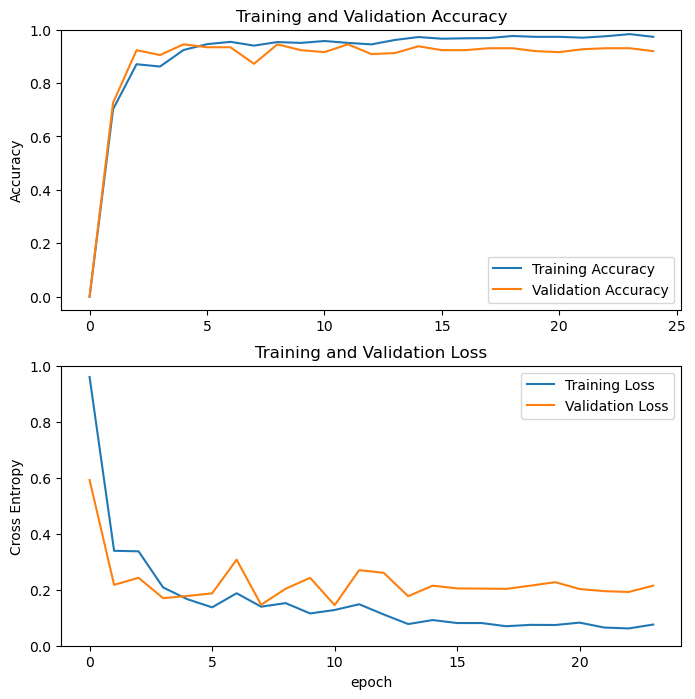

In [26]:
acc = [0.] + mobilenet_history_fine.history['accuracy']
val_acc = [0.] + mobilenet_history_fine.history['val_accuracy']

loss = mobilenet_history_fine.history['loss']
val_loss = mobilenet_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Save Model

In [27]:
mobilenet_model.save('mobilenet-covid-19-cxr-classification-model.h5')

## Model Evaluation

#### Model evaluation on the training set

In [28]:
# Load model
mobilenet_model = load_model('mobilenet-covid-19-cxr-classification-model.h5')

In [29]:
training_predictions = mobilenet_model.predict(train_dataset, batch_size = 64)

# The predictions for the each image come as an array of number of classes in the model. e.g [0.05, 0.20, 0.75] for a model predicting three classes
# In this case, the model predict the probabilties that an x-ray image is normal, covid-19 or pnemonia, and store all of these values in an array
# Hence for us to know the predicted class, we have to identify the label with corresponding largest predicted probability
# The np.argmax returns the index of the largest probability. e.g it will return 2 for an array [0.1, 0.15, 0.75] 
training_predictions_classes = np.argmax(training_predictions, axis=1)
training_labels_classes = np.argmax(train_labels, axis=1) # Position of the actual label

# Return a classification report
print(classification_report(training_labels_classes, training_predictions_classes, target_names=['normal','covid','virus']))

20/20 [==============================] - 4s 188ms/step
              precision    recall  f1-score   support

      normal       0.94      0.95      0.94       468
       covid       0.92      0.94      0.93       433
       virus       0.99      0.96      0.98       375

    accuracy                           0.95      1276
   macro avg       0.95      0.95      0.95      1276
weighted avg       0.95      0.95      0.95      1276



##### Confusion Matrix 1

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          target_names = ['Normal','Covid-19','Viral Pneumonia']):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names = target_names

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

20/20 [==============================] - 4s 188ms/step


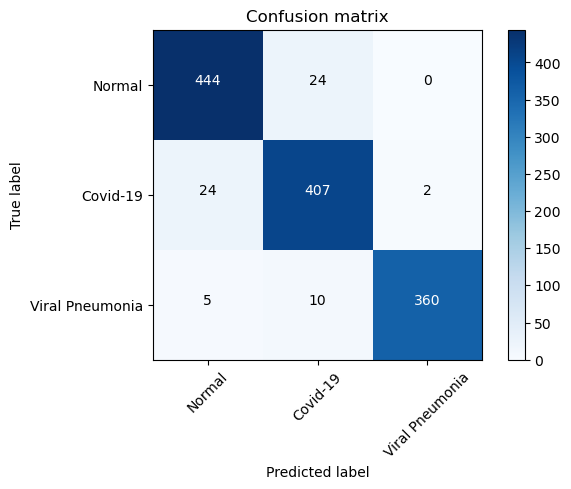

In [31]:
# Predict the values from the training dataset
training_predictions = mobilenet_model.predict(train_dataset, batch_size=64)
# Convert predictions classes from one hot vectors to label encodings
training_predictions_classes = np.argmax(training_predictions, axis = 1)
training_labels_classes = np.argmax(train_labels, axis =1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(training_labels_classes, training_predictions_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

#### Model Evaluation on the validation set 
##### Classification Report 2

In [32]:
validation_predictions = mobilenet_model.predict(validation_dataset, batch_size = 64)

# The predictions for the each image come as an array of number of classes in the model. e.g [0.05, 0.20, 0.75] for a model predicting three classes
# In this case, the model predict the probabilties that an x-ray image is normal, covid-19 or pnemonia, and store all of these values in an array
# Hence for us to know the predicted class, we have to identify the label with corresponding largest predicted probability
# The np.argmax returns the index of the largest probability. e.g it will return 2 for an array [0.1, 0.15, 0.75] 
validation_predictions_classes = np.argmax(validation_predictions, axis=1)
validation_labels_classes = np.argmax(validation_labels, axis=1) # Position of the actual label

# Return a classification report
    
print(classification_report(validation_labels_classes, validation_predictions_classes, target_names=['normal','covid','virus']))

5/5 [==============================] - 1s 317ms/step
              precision    recall  f1-score   support

      normal       0.94      0.95      0.95       100
       covid       0.92      0.94      0.93        93
       virus       0.99      0.95      0.97        81

    accuracy                           0.95       274
   macro avg       0.95      0.95      0.95       274
weighted avg       0.95      0.95      0.95       274



##### Confusion Matrix 2

5/5 [==============================] - 1s 187ms/step


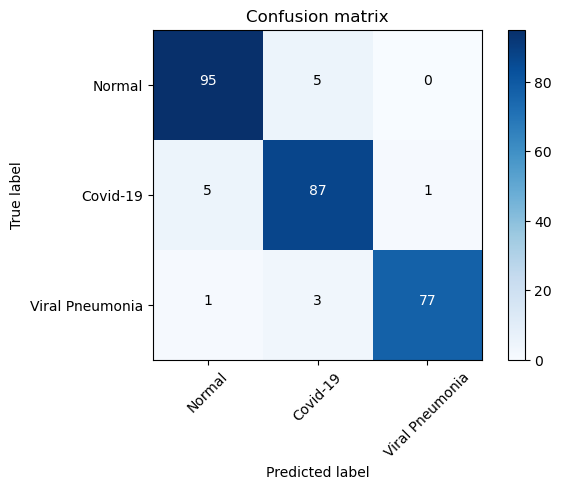

In [33]:
# Predict the values from the validation dataset
validation_predictions = mobilenet_model.predict(validation_dataset, batch_size=64)
# Convert predictions classes to one hot vectors 
validation_predictions_classes = np.argmax(validation_predictions, axis = 1)
validation_labels_classes = np.argmax(validation_labels, axis = 1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx_2 = confusion_matrix(validation_labels_classes, validation_predictions_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_2, classes = range(3)) 

#### Model Evaluation on the test set

In [34]:
test_predictions = mobilenet_model.predict(test_dataset, batch_size = 64)

# The predictions for the each image come as an array of number of classes in the model. e.g [0.05, 0.20, 0.75] for a model predicting three classes
# In this case, the model predict the probabilties that an x-ray image is normal, covid-19 or pnemonia, and store all of these values in an array
# Hence for us to know the predicted class, we have to identify the label with corresponding largest predicted probability
# The np.argmax returns the index of the largest probability. e.g it will return 2 for an array [0.1, 0.15, 0.75] 
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_labels_classes = np.argmax(test_labels, axis=1) # Position of the actual label

# Return a classification report
    
print(classification_report(test_labels_classes, test_predictions_classes, target_names=['normal','covid','virus']))

5/5 [==============================] - 1s 252ms/step
              precision    recall  f1-score   support

      normal       0.90      0.93      0.92       100
       covid       0.90      0.90      0.90        93
       virus       0.99      0.95      0.97        80

    accuracy                           0.93       273
   macro avg       0.93      0.93      0.93       273
weighted avg       0.93      0.93      0.93       273



##### Confusion Matrix 3

5/5 [==============================] - 1s 171ms/step


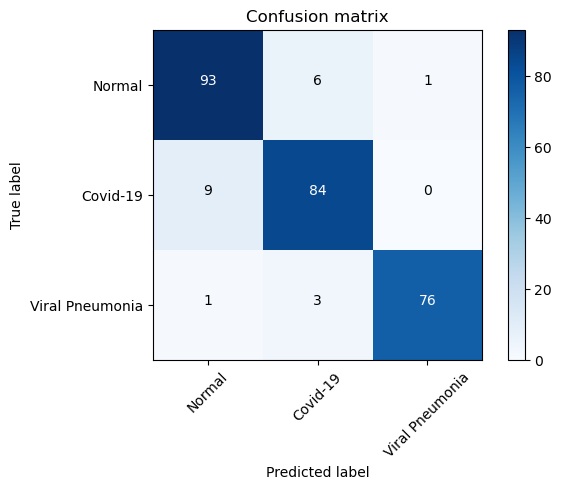

In [35]:
# Predict the values from the validation dataset
test_predictions = mobilenet_model.predict(test_dataset, batch_size=64)
# Convert predictions classes to one hot vectors 
test_predictions_classes = np.argmax(test_predictions, axis = 1)
test_labels_classes = np.argmax(test_labels, axis =1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx_3 = confusion_matrix(test_labels_classes, test_predictions_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_3, classes = range(3)) 

#### Model retraining and fine-tuning using all the dataset <a class="anchor" id="4-4"></a>

##### Merge all the datasets and labels

In [36]:
merged_dataset = np.concatenate((train_dataset, validation_dataset), axis=0)
merged_dataset = np.concatenate((merged_dataset, test_dataset), axis=0)
merged_labels = np.concatenate((train_labels, validation_labels), axis=0)
merged_labels = np.concatenate((merged_labels, test_labels), axis=0)
merged_dataset.shape, merged_labels.shape

((1823, 224, 224, 3), (1823, 3))

##### Fine-tune the Model using the merged datasets and labels

In [37]:
base_mobilenet_model = mobilenet_model.layers[2] # MobileNetV2 Architecture
base_mobilenet_model.trainable = True

# The MobileNet Model has 155 layers (the prediction layer inclusive)
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = True


optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

mobilenet_model.compile(optimizer = optimizer,
                        loss = loss,
                        metrics = metrics)

In [38]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

mobilenet_history_fine_final = mobilenet_model.fit(merged_dataset, merged_labels,
                                            epochs = total_epochs,
                                            batch_size = batch_size,
                                            initial_epoch = mobilenet_history_fine.epoch[-1],
                                            callbacks = [callback, reduce_lr], 
                                            shuffle = True)

Epoch 60/70
29/29 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8634WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 30s 852ms/step - loss: 0.4412 - accuracy: 0.8634 - lr: 1.0000e-04
Epoch 61/70
29/29 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9238WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 24s 822ms/step - loss: 0.2138 - accuracy: 0.9238 - lr: 1.0000e-04
Epoch 62/70
29/29 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9451WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 24s 822ms/step - loss: 0.1423 - accuracy: 0.9451 - lr: 1.0000e-04
Epoch 63/70
29/29 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9556WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 23s 794ms/step - loss: 0.1412 - accuracy: 0.9556 - lr: 1.0000e-04
Epoch 64/70
29/29 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9490WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 22s 765ms/step - loss: 0.1515 - accuracy: 0.9490 - lr: 1.0000e-04
Epoch 65/70
29/29 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9430WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 23s 796ms/step - loss: 0.1633 - accuracy: 0.9430 - lr: 1.0000e-04
Epoch 66/70
29/29 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9539WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 24s 839ms/step - loss: 0.1258 - accuracy: 0.9539 - lr: 1.0000e-04
Epoch 67/70
29/29 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9419WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 24s 827ms/step - loss: 0.1686 - accuracy: 0.9419 - lr: 1.0000e-04
Epoch 68/70
29/29 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9397WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 24s 843ms/step - loss: 0.1735 - accuracy: 0.9397 - lr: 1.0000e-04
Epoch 69/70
29/29 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9490WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 25s 865ms/step - loss: 0.1489 - accuracy: 0.9490 - lr: 1.0000e-04
Epoch 70/70
29/29 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9523WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


29/29 [==============================] - 25s 861ms/step - loss: 0.1367 - accuracy: 0.9523 - lr: 1.0000e-04


##### Save the Model

In [39]:
mobilenet_model.save('mobilenet-covid-19-cxr-classification-final-model.h5')

#### Model Evaluation on all datasets and labels
##### Classification Report 4

In [40]:
# Load model
mobilenet_model = load_model('mobilenet-covid-19-cxr-classification-final-model.h5')

In [41]:
merged_dataset_predictions = mobilenet_model.predict(merged_dataset, batch_size = 64)

# The predictions for the each image come as an array of number of classes in the model. e.g [0.05, 0.20, 0.75] for a model predicting three classes
# In this case, the model predict the probabilties that an x-ray image is normal, covid-19 or pnemonia, and store all of these values in an array
# Hence for us to know the predicted class, we have to identify the label with corresponding largest predicted probability
# The np.argmax returns the index of the largest probability. e.g it will return 2 for an array [0.1, 0.15, 0.75] 
merged_dataset_predictions_classes = np.argmax(merged_dataset_predictions, axis=1)
merged_dataset_labels_classes = np.argmax(merged_labels, axis=1) # Position of the actual label

# Return a classification report
    
print(classification_report(merged_dataset_labels_classes, merged_dataset_predictions_classes, target_names=['normal','covid','virus']))

29/29 [==============================] - 8s 245ms/step
              precision    recall  f1-score   support

      normal       0.89      0.99      0.94       668
       covid       0.99      0.88      0.93       619
       virus       1.00      0.98      0.99       536

    accuracy                           0.95      1823
   macro avg       0.96      0.95      0.95      1823
weighted avg       0.96      0.95      0.95      1823



##### Confusion Matrix 4

29/29 [==============================] - 7s 228ms/step


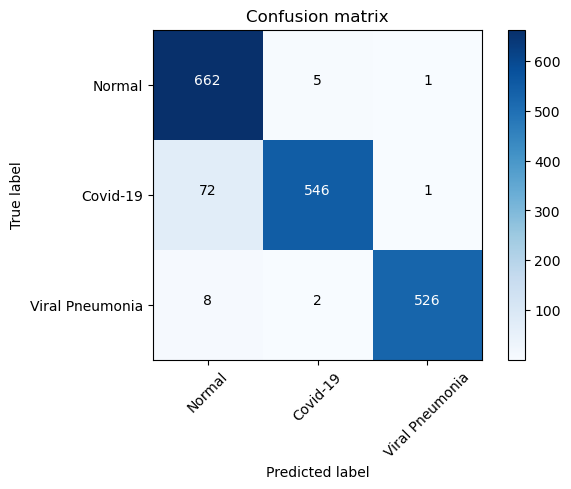

In [42]:
merged_dataset_predictions = mobilenet_model.predict(merged_dataset, batch_size=64)
merged_dataset_predictions_classes = np.argmax(merged_dataset_predictions, axis = 1)
merged_dataset_labels_classes = np.argmax(merged_labels, axis =1)
confusion_mtx_4 = confusion_matrix(merged_dataset_labels_classes, merged_dataset_predictions_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_4, classes = range(3)) 

#### Predict Random Images from the merged dataset 

In [43]:
predictions = mobilenet_model.predict(merged_dataset, batch_size = 64)
prediction_classes = np.argmax(predictions, axis = 1)
true_classes = np.argmax(merged_labels, axis = 1)

29/29 [==============================] - 7s 239ms/step


In [44]:
class_names = {0: "Normal CXR", 1 : "Viral Pneumonia CXR", 2: "COVID-19 CXR"}

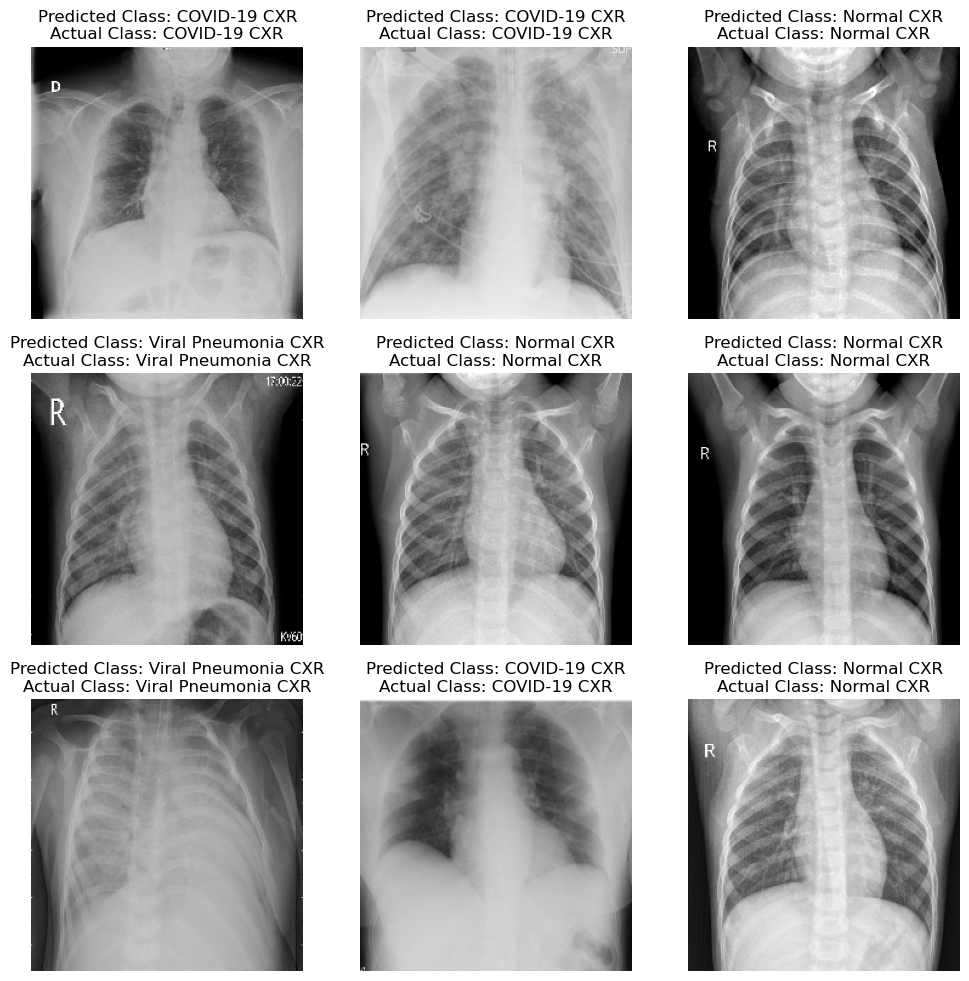

In [45]:
plt.figure(figsize=(12, 12))
for image in range(9):
    ax = plt.subplot(3, 3, image + 1)
    plt.imshow(merged_dataset[image], cmap = "gray")
    plt.title("Predicted Class: " + str(class_names[prediction_classes[image]]) + "\n" +"Actual Class: " + str(class_names[true_classes[image]]))
    plt.axis("off")


In [46]:
import numpy as np
from PIL import Image

from PIL import Image

def preprocess_image(image_path):
    # Load the image using PIL
    image = Image.open(image_path)
    # Resize the image to the required input size (224x224 pixels)
    image = image.resize((224, 224))
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Ensure the image has 3 color channels (RGB)
    if len(image_array.shape) == 2:
        # If the image is grayscale, convert it to RGB
        image_array = np.stack((image_array,) * 3, axis=-1)
    elif image_array.shape[2] == 4:
        # If the image has an alpha channel, remove it
        image_array = image_array[:, :, :3]
    # Normalize pixel values to the range [0, 1]
    image_array = image_array / 255.0
    # Add batch dimension to match the model's input shape
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array


In [47]:
class_names = {0: "Normal CXR", 1 : "Viral Pneumonia CXR", 2: "COVID-19 CXR"}

In [48]:
# Define the path to your image
image_path = "COVID_IEEE/virus/person1_virus_6.jpeg"

# Preprocess the image
preprocessed_image = preprocess_image(image_path)
print("Input Shape:", preprocessed_image.shape)
prediction = mobilenet_model.predict(preprocessed_image)

# Use the model to predict class probabilities for the image
prediction = mobilenet_model.predict(preprocessed_image)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to its corresponding label
predicted_class_label = class_names[predicted_class_index]

print("Predicted class:", predicted_class_label)


Input Shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
Predicted class: Viral Pneumonia CXR
